<h3>Report</h3>

In [1]:
import sys
sys.path.append('..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import seaborn as sns

<h3>Loading Models</h3>

In [3]:
from core.network import *
from core.trainer import *
from core.visualization import *

In [4]:
device = torch.device("cuda:0")
dir_load = '../models/'

In [5]:
net = LSTM(1, 98, 9, num_layers=3, device=device).to(device)
model = LSTMTrainer(net, device=device)
model2 = LSTMTrainer(net, device=device)

<h3>Dataloading for Eval</h3>

In [6]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [7]:
from core.getdata import *
from core.dataset import * 
from core.dataset2 import *

In [8]:
data = DatasetPolar(ligands, polarization, replicas, size)
data2 = DatasetNaive(ligands, replicas, size)

In [9]:
from torch.utils.data import Dataset
from torchvision import datasets

In [10]:
print(len(data), 0.25 * len(data)) # we'll test our data on 25% of the dataset
print(len(data2), 0.25 * len(data2))

69552 17388.0
11592 2898.0


In [11]:
_, datatest = torch.utils.data.random_split(data, [69552 - 17388 - 24, 17388 + 24])
_, dataset2 = torch.utils.data.random_split(data2, [11592 - 2880, 2880]) # 302
testloader = torch.utils.data.DataLoader(datatest, batch_size=32, shuffle=True)
testloader2 = torch.utils.data.DataLoader(dataset2, batch_size=16, shuffle=True)

<h3>Evaluation Loop</h3>

In [12]:
model.load(dir_load + 'lstm1.pth') # polarized

In [13]:
polarization_true, polarization_pred, polarized_prob = np.empty([32,]).T, np.empty([32,]).T, np.empty([32,9])

In [14]:
for x, y in testloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    polarization_true = np.hstack([polarization_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    # y_prob = np.amax(y_pred, axis=1)
    # import pdb; pdb.set_trace()
    polarized_prob = np.vstack([polarized_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    polarization_pred = np.hstack([polarization_pred, y_pred.T])
    #y_true = (32, ); y_pred = (32, ); y_prob = (32, 9)

In [15]:
model2.load(dir_load + 'lstm.pth') # naive

In [16]:
naive_true, naive_pred, naive_prob = np.empty([16,]).T, np.empty([16,]).T, np.empty([16,9])

In [17]:
for x2, y2 in testloader2:
    x2, y2 = x2.to(device), y2.to(device)
    y_true = y2.detach().cpu().numpy()
    naive_true = np.hstack([naive_true, y_true.T])
    y_pred = model2.network(x2)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    # y_prob = np.amax(y_pred, axis=1)
    naive_prob = np.vstack([naive_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    #import pdb; pdb.set_trace()
    naive_pred = np.hstack([naive_pred, y_pred.T])
    #y_true = (16, ); y_pred = (16, ); y_prob = (16, 9)

In [18]:
polarization_true, polarization_pred, polarized_prob = polarization_true[32:], polarization_pred[32:], polarized_prob[32:]
naive_true, naive_pred, naive_prob = naive_true[16:], naive_pred[16:], naive_prob[16:]
print(naive_true.shape, naive_pred.shape, polarization_true.shape, polarization_pred.shape, polarized_prob.shape, naive_prob.shape)

(2880,) (2880,) (17412,) (17412,) (17412, 9) (2880, 9)


In [19]:
comparison = np.vstack([polarization_true, polarization_pred]).T
comparison2 = np.vstack([naive_true, naive_pred]).T

In [20]:
df, df2 = pd.DataFrame(comparison), pd.DataFrame(comparison2)

In [21]:
print(df)

         0    1
0      3.0  3.0
1      0.0  0.0
2      5.0  5.0
3      5.0  5.0
4      4.0  4.0
...    ...  ...
17407  0.0  0.0
17408  5.0  5.0
17409  3.0  3.0
17410  0.0  0.0
17411  0.0  0.0

[17412 rows x 2 columns]


In [22]:
print(df2)

        0    1
0     2.0  2.0
1     4.0  4.0
2     4.0  4.0
3     2.0  2.0
4     1.0  1.0
...   ...  ...
2875  0.0  0.0
2876  3.0  3.0
2877  8.0  8.0
2878  3.0  3.0
2879  0.0  0.0

[2880 rows x 2 columns]


<h3>Naive/Polarized Metrics</h3>

In [23]:
# ACCURACY
print(f' Naive Accuracy: {sum(df2[0] == df2[1])/2880} \n Polarized Accuracy: {sum(df[0] == df[1])/17412}')

 Naive Accuracy: 0.9607638888888889 
 Polarized Accuracy: 0.914197105444521


In [24]:
naive_report = sklearn.metrics.classification_report(df2[0], df2[1], target_names=ligands, output_dict=True)
naive_rep = pd.DataFrame(naive_report).transpose()

polarized_report = sklearn.metrics.classification_report(df[0], df[1], target_names=ligands, output_dict=True)
polarized_rep = pd.DataFrame(polarized_report).transpose()

In [25]:
print(naive_rep)

              precision    recall  f1-score      support
TNF            0.953704  0.974763  0.964119   317.000000
R84            0.979452  0.869301  0.921095   329.000000
PIC            0.993610  0.987302  0.990446   315.000000
P3K            0.931624  0.981982  0.956140   333.000000
FLA            0.962848  0.977987  0.970359   318.000000
CpG            0.975610  0.943953  0.959520   339.000000
FSL            0.932660  0.923333  0.927973   300.000000
LPS            0.951070  0.993610  0.971875   313.000000
UST            0.969231  0.996835  0.982839   316.000000
accuracy       0.960764  0.960764  0.960764     0.960764
macro avg      0.961090  0.961007  0.960485  2880.000000
weighted avg   0.961271  0.960764  0.960440  2880.000000


In [26]:
print(polarized_rep)

              precision    recall  f1-score       support
TNF            0.927724  0.883410  0.905025   1947.000000
R84            0.937012  0.910931  0.923788   1976.000000
PIC            0.931737  0.950624  0.941086   1924.000000
P3K            0.891192  0.914407  0.902650   1881.000000
FLA            0.865130  0.904152  0.884211   1951.000000
CpG            0.889173  0.886005  0.887586   1965.000000
FSL            0.884131  0.900462  0.892222   1949.000000
LPS            0.910992  0.880767  0.895625   1929.000000
UST            0.996310  1.000000  0.998152   1890.000000
accuracy       0.914197  0.914197  0.914197      0.914197
macro avg      0.914822  0.914529  0.914483  17412.000000
weighted avg   0.914622  0.914197  0.914216  17412.000000


In [27]:
polarizedf1, naivef1, totalf1 = polarized_rep[:9], naive_rep[:9], pd.concat([polarized_rep[:9], naive_rep[:9]], axis=1)

<h4>F1 Polarized Ligands</h4>

<AxesSubplot:>

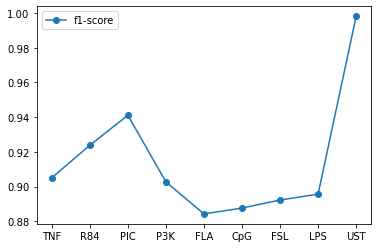

In [28]:
polarizedf1.plot(y='f1-score', style='o-')

<h4>F1 Naive Ligands</h4>

<AxesSubplot:>

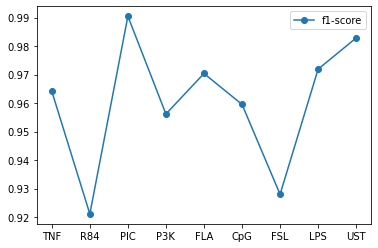

In [29]:
naivef1.plot(y='f1-score', style='o-')

<h4>F1 Ligands</h4>

<AxesSubplot:>

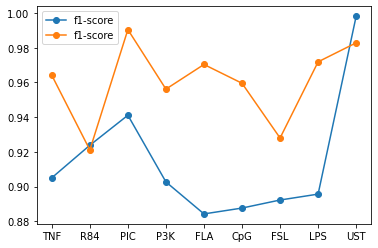

In [30]:
totalf1.plot(y='f1-score', style='o-') # orange: naive | blue: polarized

In [31]:
polarized_confusion = sklearn.metrics.confusion_matrix(df[0], df[1])
pccm = sklearn.metrics.ConfusionMatrixDisplay(polarized_confusion)

naive_confusion = sklearn.metrics.confusion_matrix(df2[0], df2[1])
nccm = sklearn.metrics.ConfusionMatrixDisplay(naive_confusion)

polarized_fraction = Fraction(polarization_true, polarized_prob)
naive_fraction = Fraction(naive_true, naive_prob)

<h4>Naive Confusion Matrix/Fraction</h4>

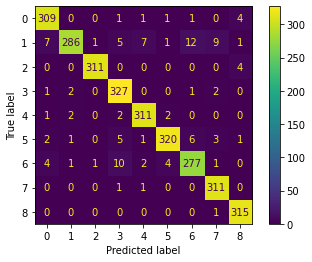

In [32]:
nccm.plot()

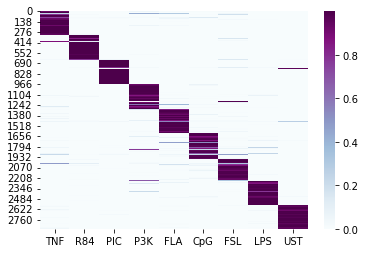

In [33]:
ncf = sns.heatmap(naive_fraction, cmap="BuPu", xticklabels=ligands) # BuPu, mako, magma

<h4>Polarized Confusion Matrix/Fraction</h4>

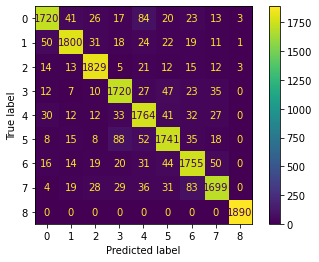

In [34]:
pccm.plot()

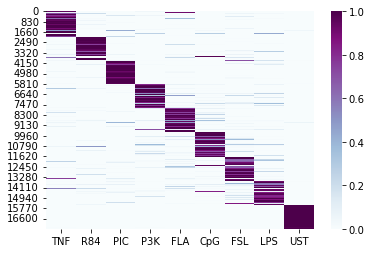

In [35]:
pcf = sns.heatmap(polarized_fraction, cmap="BuPu", xticklabels=ligands) # BuPu, mako, magma

In [36]:
# pcfm.plot()

<h3>Polarization State Analysis</h3>

In [37]:
ligands = ["TNF", "R84", "PIC", "P3K", "FLA", "CpG", "FSL", "LPS", "UST"]
polarization = ["", "ib", "ig", "i0", "i3", "i4"]
replicas, size = 2, 1288

In [38]:
unpolarized_data = DatasetPolar(ligands, [""], replicas, size)
ib = DatasetPolar(ligands, ["ib"], replicas, size)
ig = DatasetPolar(ligands, ["ig"], replicas, size)
i0 = DatasetPolar(ligands, ["i0"], replicas, size)
i3 = DatasetPolar(ligands, ["i3"], replicas, size)
i4 = DatasetPolar(ligands, ["i4"], replicas, size)

In [39]:
print(len(unpolarized_data) + len(ib) + len(ig) + len(i0) + len(i3) + len(i4))
print(len(i4))

69552
11592


In [40]:
_, unpolarizedtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, ibtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, igtest = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i0test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i3test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])
_, i4test = torch.utils.data.random_split(unpolarized_data, [11592 - 3200, 3200])

uploader = torch.utils.data.DataLoader(unpolarizedtest, batch_size=32, shuffle=True)
ibloader = torch.utils.data.DataLoader(ibtest, batch_size=32, shuffle=True)
igloader = torch.utils.data.DataLoader(igtest, batch_size=32, shuffle=True)
i0loader = torch.utils.data.DataLoader(i0test, batch_size=32, shuffle=True)
i3loader = torch.utils.data.DataLoader(i3test, batch_size=32, shuffle=True)
i4loader = torch.utils.data.DataLoader(i4test, batch_size=32, shuffle=True)

<h3>Evaluation Loop</h3>

In [41]:
model.load(dir_load + 'lstm1.pth') # polarized

In [42]:
up_true, up_pred, up_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
ib_true, ib_pred, ib_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
ig_true, ig_pred, ig_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
i0_true, i0_pred, i0_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
i3_true, i3_pred, i3_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])
i4_true, i4_pred, i4_prob = np.empty([32,]), np.empty([32,]), np.empty([32, 9])

In [43]:
for x, y in uploader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    up_true = np.hstack([up_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    up_prob = np.vstack([up_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    up_pred = np.hstack([up_pred, y_pred.T])
    
for x, y in ibloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    ib_true = np.hstack([ib_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    ib_prob = np.vstack([ib_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    ib_pred = np.hstack([ib_pred, y_pred.T])
    
for x, y in igloader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    ig_true = np.hstack([ig_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    ig_prob = np.vstack([ig_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    ig_pred = np.hstack([ig_pred, y_pred.T])
    
for x, y in i0loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i0_true = np.hstack([i0_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    i0_prob = np.vstack([i0_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    i0_pred = np.hstack([i0_pred, y_pred.T])
    
for x, y in i3loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i3_true = np.hstack([i3_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    i3_prob = np.vstack([i3_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    i3_pred = np.hstack([i3_pred, y_pred.T])
    
for x, y in i4loader:
    x, y = x.to(device), y.to(device)
    y_true = y.detach().cpu().numpy()
    i4_true = np.hstack([i4_true, y_true.T])
    y_pred = model.network(x)
    y_pred = F.softmax(y_pred, dim=1)
    y_pred = y_pred.detach().cpu().numpy()
    i4_prob = np.vstack([i4_prob, y_pred])
    y_pred = np.argmax(y_pred, axis=1)
    i4_pred = np.hstack([i4_pred, y_pred.T])

In [44]:
up_true, up_pred, up_prob = up_true[32:], up_pred[32:], up_prob[32:]
ib_true, ib_pred, ib_prob = ib_true[32:], ib_pred[32:], ib_prob[32:] 
ig_true, ig_pred, ig_prob = ig_true[32:], ig_pred[32:], ig_prob[32:]
i0_true, i0_pred, i0_prob = i0_true[32:], i0_pred[32:], i0_prob[32:]
i3_true, i3_pred, i3_prob = i3_true[32:], i3_pred[32:], i3_prob[32:]
i4_true, i4_pred, i4_prob = i4_true[32:], i4_pred[32:], i4_prob[32:]

In [45]:
print(ib_true.shape, ib_pred.shape, ib_prob.shape)
print(ig_true.shape, ig_pred.shape, ig_prob.shape)
print(i0_true.shape, i0_pred.shape, i0_prob.shape)
print(i3_true.shape, i3_pred.shape, i3_prob.shape)
print(i4_true.shape, i4_pred.shape, i4_prob.shape)

(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)
(3200,) (3200,) (3200, 9)


In [46]:
up_df = np.vstack([up_true, up_pred]).T
up_df = pd.DataFrame(up_df)
up_fraction = Fraction(up_true, up_prob)

ib_df = np.vstack([ib_true, ib_pred]).T
ib_df = pd.DataFrame(ib_df)
ib_fraction = Fraction(ib_true, ib_prob)

ig_df = np.vstack([ig_true, ig_pred]).T
ig_df = pd.DataFrame(ig_df)
ig_fraction = Fraction(ig_true, ig_prob)

i0_df = np.vstack([i0_true, i0_pred]).T
i0_df = pd.DataFrame(i0_df)
i0_fraction = Fraction(i0_true, i0_prob)

i3_df = np.vstack([i3_true, i3_pred]).T
i3_df = pd.DataFrame(i3_df)
i3_fraction = Fraction(i3_true, i3_prob)

i4_df = np.vstack([i4_true, i4_pred]).T
i4_df = pd.DataFrame(i4_df)
i4_fraction = Fraction(i4_true, i4_prob)

<h4>Unpolarized</h4>

        0    1
0     6.0  6.0
1     0.0  0.0
2     4.0  4.0
3     8.0  8.0
4     5.0  5.0
...   ...  ...
3195  1.0  1.0
3196  4.0  4.0
3197  2.0  2.0
3198  3.0  3.0
3199  8.0  8.0

[3200 rows x 2 columns]
 Accuracy: 0.885625


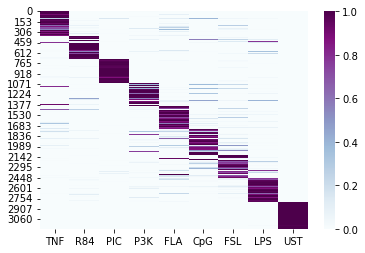

In [47]:
upcf = sns.heatmap(up_fraction, cmap = "BuPu", xticklabels=ligands)
print(up_df)
print(f' Accuracy: {sum(up_df[0] == up_df[1])/3200}')

<h4>ib (NEED TO FIX THIS)</h4>

        0    1
0     4.0  4.0
1     3.0  3.0
2     4.0  4.0
3     3.0  3.0
4     3.0  3.0
...   ...  ...
3195  8.0  8.0
3196  6.0  6.0
3197  2.0  2.0
3198  6.0  6.0
3199  8.0  8.0

[3200 rows x 2 columns]
 Accuracy: 0.8921875


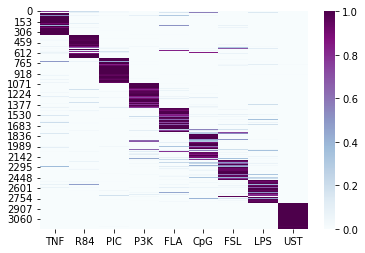

In [48]:
ibcf = sns.heatmap(ib_fraction, cmap = "BuPu", xticklabels=ligands)
print(ib_df)
print(f' Accuracy: {sum(ib_df[0] == ib_df[1])/3200}')

<h4>ig</h4>

        0    1
0     5.0  5.0
1     6.0  6.0
2     0.0  0.0
3     1.0  1.0
4     5.0  5.0
...   ...  ...
3195  1.0  1.0
3196  1.0  1.0
3197  4.0  4.0
3198  1.0  1.0
3199  3.0  5.0

[3200 rows x 2 columns]
 Accuracy: 0.8921875


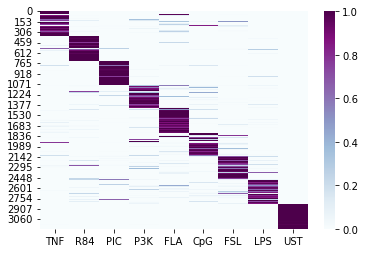

In [49]:
igcf = sns.heatmap(ig_fraction, cmap = "BuPu", xticklabels=ligands)
print(ig_df)
print(f' Accuracy: {sum(ig_df[0] == ig_df[1])/3200}')

<h4>i0</h4>

        0    1
0     0.0  1.0
1     5.0  5.0
2     0.0  4.0
3     3.0  3.0
4     7.0  7.0
...   ...  ...
3195  1.0  1.0
3196  0.0  0.0
3197  1.0  1.0
3198  5.0  5.0
3199  4.0  6.0

[3200 rows x 2 columns]
 Accuracy: 0.8903125


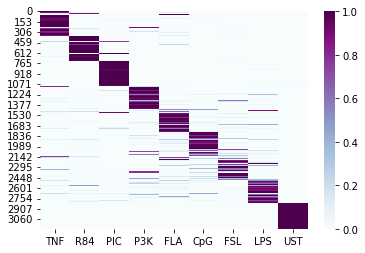

In [50]:
i0cf = sns.heatmap(i0_fraction, cmap = "BuPu", xticklabels=ligands)
print(i0_df)
print(f' Accuracy: {sum(i0_df[0] == i0_df[1])/3200}')

<h4>i3</h4>

        0    1
0     5.0  5.0
1     3.0  3.0
2     8.0  8.0
3     7.0  7.0
4     1.0  1.0
...   ...  ...
3195  6.0  6.0
3196  2.0  2.0
3197  7.0  7.0
3198  6.0  7.0
3199  2.0  2.0

[3200 rows x 2 columns]
 Accuracy: 0.8984375


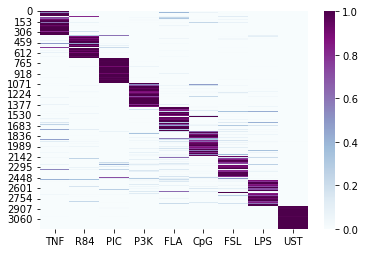

In [51]:
i3cf = sns.heatmap(i3_fraction, cmap = "BuPu", xticklabels=ligands)
print(i3_df)
print(f' Accuracy: {sum(i3_df[0] == i3_df[1])/3200}')

<h4>i4</h4>

        0    1
0     1.0  1.0
1     0.0  0.0
2     0.0  0.0
3     1.0  1.0
4     6.0  6.0
...   ...  ...
3195  4.0  4.0
3196  8.0  8.0
3197  1.0  1.0
3198  5.0  5.0
3199  8.0  8.0

[3200 rows x 2 columns]
 Accuracy: 0.8928125


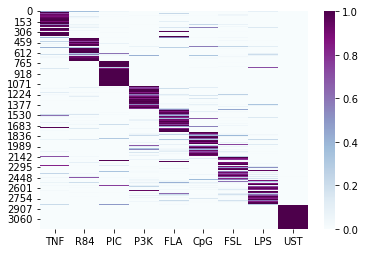

In [52]:
i4cf = sns.heatmap(i4_fraction, cmap = "BuPu", xticklabels=ligands)
print(i4_df)
print(f' Accuracy: {sum(i4_df[0] == i4_df[1])/3200}')